In [2]:
import json
import sys
import os
import numpy as np
import skimage
from scipy import ndimage
from scipy import special
from scipy import sparse
import anndata
import nibabel as nib
import pandas as pd
import datashader as ds
import time
from sklearn.decomposition import PCA
import collections
import pickle as pkl
import zarr
import h5py
import anndata as ad

import ants
import nibabel as nib

from dredFISH.Analysis.__init__plots import *
sns.set_style('white')

import importlib
from dredFISH.Analysis import powerplots
importlib.reload(powerplots)
from dredFISH.Analysis import imageu
importlib.reload(imageu)
from dredFISH.Analysis import regu
importlib.reload(regu)
from dredFISH.Analysis import basicu
importlib.reload(basicu)

<module 'dredFISH.Analysis.basicu' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/basicu.py'>

In [3]:
prj_dir = '/home/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'results/'
fig_dir = prj_dir + 'figures/'

In [89]:
ddir = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_CtxHippo/source/'
# ddir = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_SmartSeq_CtxHippo/source/'
outdir = '/scratch/10x/'

# load allen matrix

In [5]:
%%time
f = ddir + 'metadata.csv'
df1 = pd.read_csv(f, low_memory=False).set_index('sample_name')
f = ddir + 'tsne.csv'
df2 = pd.read_csv(f, low_memory=False).set_index('sample_name')
df = df1.join(df2) #.astype({'cluster_order': str})
print(df.shape)

In [7]:
df

,donor_sex_id,donor_sex_label,donor_sex_color,region_id,region_label,region_color,platform_label,cluster_order,cluster_label,cluster_color,...,cell_type_accession_id,cell_type_designation_color,cell_type_alt_alias_color,cell_type_alias_color,cell_type_accession_color,cortical_layer_label,cortical_layer_order,cortical_layer_color,Lim1,Lim2
sample_name,,,,,,,,,,,,,,,,,,,,,
ACGCAGCAGACCGGAT-L8TX_180221_01_C11,2,M,#ADC4C3,20,RSP,#2B9EAD,10X,116,116_Pvalb,#EC2D46,...,116,#EC2D46,#EC2D46,#EC2D46,#EC2D46,NaN,1,#FF7373,-2.424144,11.128505
CCATGTCAGCGCTTAT-L8TX_180221_01_C11,2,M,#ADC4C3,20,RSP,#2B9EAD,10X,364,364_DG,#413BE2,...,364,#413BE2,#413BE2,#413BE2,#413BE2,NaN,1,#FF7373,-6.130457,12.989396
GCGCAGTAGTGTCTCA-L8TX_180712_01_H05,2,M,#ADC4C3,21,TEa-PERI-ECT,#76CBE2,10X,18,18_Lamp5,#D97C80,...,18,#D97C80,#D97C80,#D97C80,#D97C80,NaN,1,#FF7373,13.357867,14.714755
GTCACGGCACCAACCG-L8TX_180712_01_H05,2,M,#ADC4C3,21,TEa-PERI-ECT,#76CBE2,10X,15,15_Lamp5,#A6666F,...,15,#A6666F,#A6666F,#A6666F,#A6666F,NaN,1,#FF7373,12.515041,14.157471
ATTGGACTCGATCCCT-L8TX_180712_01_A06,2,M,#ADC4C3,21,TEa-PERI-ECT,#76CBE2,10X,18,18_Lamp5,#D97C80,...,18,#D97C80,#D97C80,#D97C80,#D97C80,NaN,1,#FF7373,10.909149,14.514740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCACCACCT-L8TX_180115_01_E08,2,M,#ADC4C3,1,VISp,#9299FF,10X,59,59_Vip Igfbp6,#CD6DF2,...,59,#CD6DF2,#CD6DF2,#CD6DF2,#CD6DF2,NaN,1,#FF7373,17.369737,10.950998
TTTGTCATCCCAAGTA-L8TX_180115_01_E08,2,M,#ADC4C3,1,VISp,#9299FF,10X,168,168_L2/3 IT CTX,#02F970,...,168,#02F970,#02F970,#02F970,#02F970,NaN,1,#FF7373,1.385633,-7.093068
TTTGTCATCCTCAACC-L8TX_180115_01_E08,2,M,#ADC4C3,1,VISp,#9299FF,10X,168,168_L2/3 IT CTX,#02F970,...,168,#02F970,#02F970,#02F970,#02F970,NaN,1,#FF7373,1.686636,-6.341560


In [8]:
df.columns

Index(['donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id',
       'region_label', 'region_color', 'platform_label', 'cluster_order',
       'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label',
       'subclass_color', 'neighborhood_id', 'neighborhood_label',
       'neighborhood_color', 'class_order', 'class_label', 'class_color',
       'exp_component_name', 'external_donor_name_label',
       'full_genotype_label', 'facs_population_plan_label',
       'injection_roi_label', 'injection_materials_label',
       'injection_method_label', 'injection_type_label', 'full_genotype_id',
       'full_genotype_color', 'external_donor_name_id',
       'external_donor_name_color', 'facs_population_plan_id',
       'facs_population_plan_color', 'injection_materials_id',
       'injection_materials_color', 'injection_method_id',
       'injection_method_color', 'injection_roi_id', 'injection_roi_color',
       'injection_type_id', 'injection_type_color',
       'cell

In [9]:
df.iloc[0]

donor_sex_id                                                      2
donor_sex_label                                                   M
donor_sex_color                                             #ADC4C3
region_id                                                        20
region_label                                                    RSP
region_color                                                #2B9EAD
platform_label                                                  10X
cluster_order                                                   116
cluster_label                                             116_Pvalb
cluster_color                                               #EC2D46
subclass_order                                                    8
subclass_label                                                Pvalb
subclass_color                                              #D93137
neighborhood_id                                                   2
neighborhood_label                              

In [10]:
df.head()
palette_clsts = df.groupby('cluster_label').first()['cluster_color'] #: cluster_color)
palette_clsts #.to_dict()

cluster_label
100_Sst         #F2841A
101_Sst         #A62A2F
102_Sst HPF     #FF8A00
103_Sst HPF     #BF720B
104_Sst HPF     #E6A705
                 ...   
96_Sst          #BF880B
97_Sst          #C39317
98_Sst          #A6770D
99_Sst          #F28403
9_Lamp5 Lhx6    #EC8E6E
Name: cluster_color, Length: 387, dtype: object

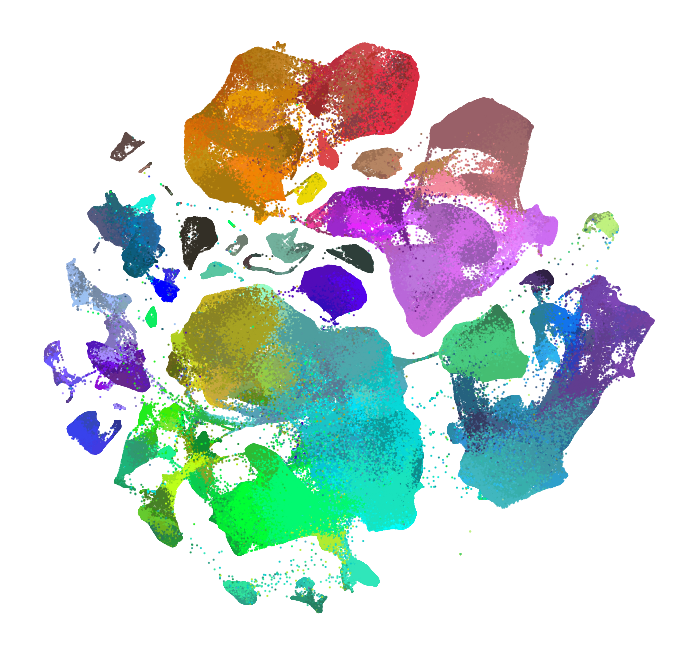

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=df, 
                x='Lim1', y='Lim2', 
                hue='cluster_label', 
                palette=palette_clsts.to_dict(),
                s=1, 
                ax=ax,
                edgecolor='none',
                legend=False,
               )
ax.set_aspect('equal')
ax.axis('off')
plt.show()

## Unpack the Allen hdf5 file

- `data` 
    - `exon` (csc_matrix)
    - `t_exon` (csc_matrix)
    - `total_exon_counts` (1d array)
- `gene_names`  (1d array)
- `sample_names`  (1d array)


csc_matrix: dims, i, p, x
scipy
`csc_matrix((data, indices, indptr), [shape=(M, N)])`

In [56]:
ti = time.time()
f = ddir + 'expression_matrix.hdf5'
with h5py.File(f, 'r') as fh:
    print(fh.keys())
    print(fh['data'].keys())
    
    print(fh['data']['counts'])
    print(fh['data']['gene'])# t is just the transpose
    print(fh['data']['samples'])
    print(fh['data']['shape'])
    
    print(fh['data']['shape'][()])
    
    mat = fh['data']['counts'][:,:100] # [gene, cell]
    
    genes = fh['data']['gene'][()]
    genes = np.array([gene.decode() for gene in genes])
    
    cells = fh['data']['samples'][()]
    cells = np.array([cell.decode() for cell in cells])
    
genes_10x = genes.copy()
mat_10x = mat

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['counts', 'gene', 'samples', 'shape']>
<HDF5 dataset "counts": shape (31053, 1169320), type "<i4">
<HDF5 dataset "gene": shape (31053,), type "|S30">
<HDF5 dataset "samples": shape (1169320,), type "|S36">
<HDF5 dataset "shape": shape (2,), type "<i4">
[1169320   31053]


In [85]:
# DPNMF matrix 
f = f'/bigstore/GeneralStorage/fangming/projects/dredfish/data/dpnmf.csv' 
pmat = pd.read_csv(f, index_col=0)
print(pmat.shape)

# for each allen cluster, get their DPNMF measurements
# remove genes with zero counts
pmat = pmat[pmat.sum(axis=1) > 0]
# 5818 genes, 5818 (all) overlap with 10x, 5576 overlap with Allen SS  
genes = np.intersect1d(pmat.index.values, genes_10x)
genes_idx = basicu.get_index_from_array(genes_10x, genes)
print(pmat.shape, genes_10x.shape, genes.shape)

pmat = pmat.loc[genes]
pmat

(9711, 24)
(5818, 24) (31053,) (5818,)


,RS0109_cy5,RS0175_cy5,RS0237_cy5,RS0307_cy5,RS0332_cy5,RS0384_atto565,RS0406_atto565,RS0451_atto565,RS0468_atto565,RS0548_atto565,...,RS643.0_alexa488,RS740.0_alexa488,RS810.0_alexa488,RSN9927.0_cy5,RSN2336.0_cy5,RSN1807.0_cy5,RSN4287.0_atto565,RSN1252.0_atto565,RSN9535.0_atto565,RS0095_cy5
0610010F05Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
0610012G03Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610043K17Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1110002L01Rik,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1110004E09Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zscan18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,0,0,0
Zswim1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Zswim8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
Zyg11b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27


In [ ]:
%%time
Xcell = mat_10x.T

# # correct for library size (normalization) and projection 
libsizes = Xcell.sum(axis=1)
medsize = np.median(libsizes)

Xcr_norm = (Xcell[:,genes_idx]/libsizes.reshape(-1,1))*medsize
Xcr_norm = Xcr_norm.dot(pmat)

In [90]:
# save to scratch
i = 0
np.save(f'{outdir}{i}.npy', Xcr_norm)